Reusing code from https://www.kaggle.com/code/agggshambhavi/pytorch-brain-mri-binary-segmentation

# Imports

In [24]:
!pip install opencv-python-headless sklearn

In [45]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import cv2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Defining parameters

In [47]:
data_dir = "../data/lgg-mri-segmentation/kaggle_3m/"

train_fraction = 0.8
validation_fraction = 0.2
batch_size = 16

input_dim = 256
input_ch = 3
output_dim = 256
output_ch = 1

learning_rate = 0.01
epochs = 25
SEED1 = 1
SEED2 = 2

# Reading images path

In [48]:
dirs, images, masks = [], [], []

for root, folders, files in  os.walk(data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

directory                        images  \
0  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_75.tif   
1  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_63.tif   
2  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_70.tif   
3  TCGA_HT_A61A_20000127   TCGA_HT_A61A_20000127_4.tif   
4  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_42.tif   

                               masks  
0  TCGA_HT_A61A_20000127_75_mask.tif  
1  TCGA_HT_A61A_20000127_63_mask.tif  
2  TCGA_HT_A61A_20000127_70_mask.tif  
3   TCGA_HT_A61A_20000127_4_mask.tif  
4  TCGA_HT_A61A_20000127_42_mask.tif

In [49]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [50]:
PathDF.head()

directory                        images  \
0  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_75.tif   
1  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_63.tif   
2  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_70.tif   
3  TCGA_HT_A61A_20000127   TCGA_HT_A61A_20000127_4.tif   
4  TCGA_HT_A61A_20000127  TCGA_HT_A61A_20000127_42.tif   

                               masks  diagnosis  
0  TCGA_HT_A61A_20000127_75_mask.tif        0.0  
1  TCGA_HT_A61A_20000127_63_mask.tif        0.0  
2  TCGA_HT_A61A_20000127_70_mask.tif        0.0  
3   TCGA_HT_A61A_20000127_4_mask.tif        0.0  
4  TCGA_HT_A61A_20000127_42_mask.tif        1.0

In [51]:
train_df, valid_df = train_test_split(PathDF, random_state=SEED1,
                                 test_size = validation_fraction)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])

train_df2, valid_df2 = train_test_split(PathDF, random_state=SEED2,
                                 test_size = validation_fraction)

print('Train2:', train_df2.shape[0])
print('Valid2:', valid_df2.shape[0])

Train: 3144
Valid: 786
Train2: 3144
Valid2: 786


In [52]:
train_df

directory                        images  \
1544  TCGA_FG_7637_20000922  TCGA_FG_7637_20000922_32.tif   
2433  TCGA_HT_7884_19980913   TCGA_HT_7884_19980913_2.tif   
3474  TCGA_HT_7856_19950831   TCGA_HT_7856_19950831_9.tif   
3711  TCGA_HT_A5RC_19990831  TCGA_HT_A5RC_19990831_30.tif   
195   TCGA_FG_A4MT_20020212   TCGA_FG_A4MT_20020212_5.tif   
...                     ...                           ...   
905   TCGA_HT_7684_19950816   TCGA_HT_7684_19950816_8.tif   
3839  TCGA_FG_6688_20020215   TCGA_FG_6688_20020215_1.tif   
1096  TCGA_DU_5849_19950405  TCGA_DU_5849_19950405_12.tif   
235   TCGA_DU_A5TR_19970726  TCGA_DU_A5TR_19970726_25.tif   
1061  TCGA_DU_5851_19950428  TCGA_DU_5851_19950428_33.tif   

                                  masks  diagnosis  
1544  TCGA_FG_7637_20000922_32_mask.tif        0.0  
2433   TCGA_HT_7884_19980913_2_mask.tif        0.0  
3474   TCGA_HT_7856_19950831_9_mask.tif        0.0  
3711  TCGA_HT_A5RC_19990831_30_mask.tif        0.0  
195    TCGA_FG_A4MT_20020212_5_mask.tif        0.0  
...                                 ...        ...  
905    TCGA_HT_7684_19950816_8_mask.tif        0.0  
3839   TCGA_FG_6688_20020215_1_mask.tif        0.0  
1096  TCGA_DU_5849_19950405_12_mask.tif        0.0  
235   TCGA_DU_A5TR_19970726_25_mask.tif        1.0  
1061  TCGA_DU_5851_19950428_33_mask.tif        0.0  

[3144 rows x 4 columns]

In [53]:
train_df2

directory                        images  \
2686  TCGA_DU_7306_19930512  TCGA_DU_7306_19930512_16.tif   
2381  TCGA_CS_5397_20010315  TCGA_CS_5397_20010315_14.tif   
1065  TCGA_DU_5851_19950428  TCGA_DU_5851_19950428_20.tif   
1380  TCGA_DU_A5TU_19980312   TCGA_DU_A5TU_19980312_4.tif   
810   TCGA_DU_A5TW_19980228  TCGA_DU_A5TW_19980228_24.tif   
...                     ...                           ...   
3606  TCGA_FG_A60K_20040224  TCGA_FG_A60K_20040224_41.tif   
1608  TCGA_DU_A5TP_19970614  TCGA_DU_A5TP_19970614_26.tif   
2541  TCGA_DU_A5TS_19970726  TCGA_DU_A5TS_19970726_24.tif   
2575  TCGA_HT_7860_19960513   TCGA_HT_7860_19960513_3.tif   
3240  TCGA_CS_6186_20000601  TCGA_CS_6186_20000601_22.tif   

                                  masks  diagnosis  
2686  TCGA_DU_7306_19930512_16_mask.tif        1.0  
2381  TCGA_CS_5397_20010315_14_mask.tif        0.0  
1065  TCGA_DU_5851_19950428_20_mask.tif        1.0  
1380   TCGA_DU_A5TU_19980312_4_mask.tif        0.0  
810   TCGA_DU_A5TW_19980228_24_mask.tif        1.0  
...                                 ...        ...  
3606  TCGA_FG_A60K_20040224_41_mask.tif        1.0  
1608  TCGA_DU_A5TP_19970614_26_mask.tif        1.0  
2541  TCGA_DU_A5TS_19970726_24_mask.tif        0.0  
2575   TCGA_HT_7860_19960513_3_mask.tif        0.0  
3240  TCGA_CS_6186_20000601_22_mask.tif        0.0  

[3144 rows x 4 columns]

# Creating Torch Datasets and DataLoaders

In [54]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample            

Preprocessing function to apply to images

In [55]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

In [67]:
dataset = MRI_Dataset(train_df)
sample = dataset[13]

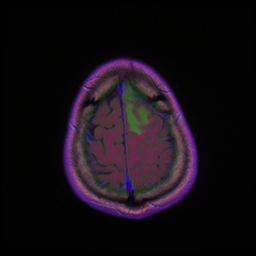

In [68]:
sample[0]

In [37]:
train_data = MRI_Dataset(train_df, transform=PairedToTensor())
valid_data = MRI_Dataset(valid_df, transform=PairedToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size,
                         shuffle=False)

# Loading pretrained model

In [38]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


# Defining utility functions

Custom metrics

In [39]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

In [40]:
def iou(pred, label):
    intersection = (pred * label).sum()
    union = pred.sum() + label.sum() - intersection
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

Training loop

In [41]:
def train_loop(model, optimizer, criterion, train_loader):
    running_loss = 0
    model.train()
    
    final_dice_coef = 0 

    for i, data in enumerate(train_loader, 0):
        imgs, masks = data

        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Validation loop

In [42]:
def eval_loop(model, criterion, eval_loader):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        for i, data in enumerate(eval_loader, 0):
            
            imgs, masks = data
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

General training function

In [43]:
def train(model, optimizer, criterion, scheduler, train_loader, valid_loader,
          num_epochs = epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader)
        
        val_metrics = eval_loop(model, criterion, valid_loader)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        #if val_metrics["loss"] <= valid_loss_min:
        #    torch.save(model.state_dict(), "UNET.pt")
        #    valid_loss_min = val_metrics["loss"]
        
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

# Train model

In [44]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
# Only 1 epoch, just to make sure the code is running - can take a while with CPU only
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader, num_epochs=1)

KeyboardInterrupt: 